# **Ciencia de Datos para Sensores Inteligentes**
### **Práctica 2: Procesamiento de imágenes.**

Ian Svén Castellanos Soto.

El objetivo de esta práctica es desarrollar un clasificador de caminata basado en análisis de video. 

Dicho conjunto de datos fue creado de manera colaborativa por los estudiantes del curso, el docente responsable y dos de sus estudiantes de doctorado con una cámara estéreo *Intel Realsense D455*. Se grabaron cuatro archivos `.bag` por cada uno de los trece participantes; cada uno de estos videos tiene una duración aproximada de diez segundos en los cuales caminan hacia la cámara. El conjunto de datos final contiene 52 de estos archivos.

Los archivos fueron nombrados como ID_MUESTRA.wav, donde ID es un nombre del participante (o dos en caso de coincidencias) y MUESTRA indica el número de muestra (01 a 03).

In [215]:
import os
from IPython.display import Image
from collections import Counter

# Procesamiento de video
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pyrealsense2 as rs   
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Aprendizaje de máquina
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## Preprocesamiento de datos

In [16]:
dataset_path = "data/train"

dataset_df = pd.DataFrame(columns=["name", "path", "id", "sample"])

rows = []
for file_name in os.listdir(dataset_path):
    if not file_name.endswith(".bag"):
        continue
    name, _ = os.path.splitext(file_name)
    parts = name.split("_")
    if len(parts) != 2:
        continue
    id, sample = parts
    rows.append({
        "name": file_name,
        "path": os.path.join(dataset_path, file_name),
        "id": id,
        "sample": sample
    })

dataset_df = pd.concat([dataset_df, pd.DataFrame(rows)], ignore_index=True)

Estos son los videos que formarán el conjunto de datos de entrenamiento, separados por id.

In [3]:
dataset_df

,name,path,id,sample
0,DianaItzel_01.bag,data/train\DianaItzel_01.bag,DianaItzel,01
1,DianaItzel_02.bag,data/train\DianaItzel_02.bag,DianaItzel,02
2,DianaItzel_03.bag,data/train\DianaItzel_03.bag,DianaItzel,03
3,DianaItzel_04.bag,data/train\DianaItzel_04.bag,DianaItzel,04
4,DianaMinerva_01.bag,data/train\DianaMinerva_01.bag,DianaMinerva,01
5,DianaMinerva_02.bag,data/train\DianaMinerva_02.bag,DianaMinerva,02
6,DianaMinerva_03.bag,data/train\DianaMinerva_03.bag,DianaMinerva,03
7,DianaMinerva_04.bag,data/train\DianaMinerva_04.bag,DianaMinerva,04
8,Edgar_01.bag,data/train\Edgar_01.bag,Edgar,01
9,Edgar_02.bag,data/train\Edgar_02.bag,Edgar,02


A continuación se muestran los metadatos de una de las grabaciones del conjunto de prueba. Esto con el fin de mostrar las características comúnes de todos los datos: 
- Los _streams_ de la grabación (color y profundidad)
- La resolución y tasa de refrescamiento de cada video. 

Si bien todos los datos tienen una longitud similar (alrededor de los diez segundos), variaciones ligeras en la velocidad de la caminata de los participantes resultan en archivos de longitudes distintas. 

Otro punto a considerar es la diferencia de hasta dos segundos entre el inicio de la grabación y de algunas caminatas, así como el hecho de que al final de la misma solo la mitad superior de los participantes es visible, lo cual indica que no es ideal procesar el video completo.

In [ ]:
file = "Ian_01.bag"
print(f"Archivo: {file}.")

pipeline = rs.pipeline()
config = rs.config()
config.enable_device_from_file(os.path.join(dataset_path, file), repeat_playback=False)

profile = pipeline.start(config)
device = profile.get_device()
playback = device.as_playback()
playback.set_real_time(False)

print("Streams:")
for s in profile.get_streams():
    v = s.as_video_stream_profile()
    print(f"  {s.stream_type().name}: "
          f"{v.width()}x{v.height()} @ {v.fps()} FPS, "
          f"formato={s.format().name}.")
          
duration = playback.get_duration()
pipeline.stop()

print(f"Duración: {duration} segundos.")

Archivo: Ian_01.bag.
Streams:
  depth: 1280x720 @ 30 FPS, formato=z16.
  color: 1280x720 @ 30 FPS, formato=bgr8.
Duración: 0:00:08.812439 segundos.


## Extracción de puntos clave

Se utilizarán `mediapipe` para la extracción de puntos clave, mientras que `pyrealsense2` encontrará la profundidad de cada uno de estos para completar la caminata de los participantes a lo largo del tiempo.
  
Se considerán relevantes, y por consiguiente se incluirán, a los siguientes puntos:
- Cabeza (0).
- Hombros (11 y 12)
- Codos (13 y 14)
- Muñecas (15 y 16)
- Cadera (23 y 34)
- Rodillas (25 y 26)
- Tobillos (27 y 28)
- Talones (29 y 30)
- Punta del pie (31 y 32)

Se desecharán los cuadros de las grabaciones en que se pierdan estos puntos.

Por consiguiente, se incluirán los puntos 0, 11 a 16 y 23 a 32 de `pose_landmarker_heavy.task`, que se muestran en la siguiente imagen tomada de [esta](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker) página:

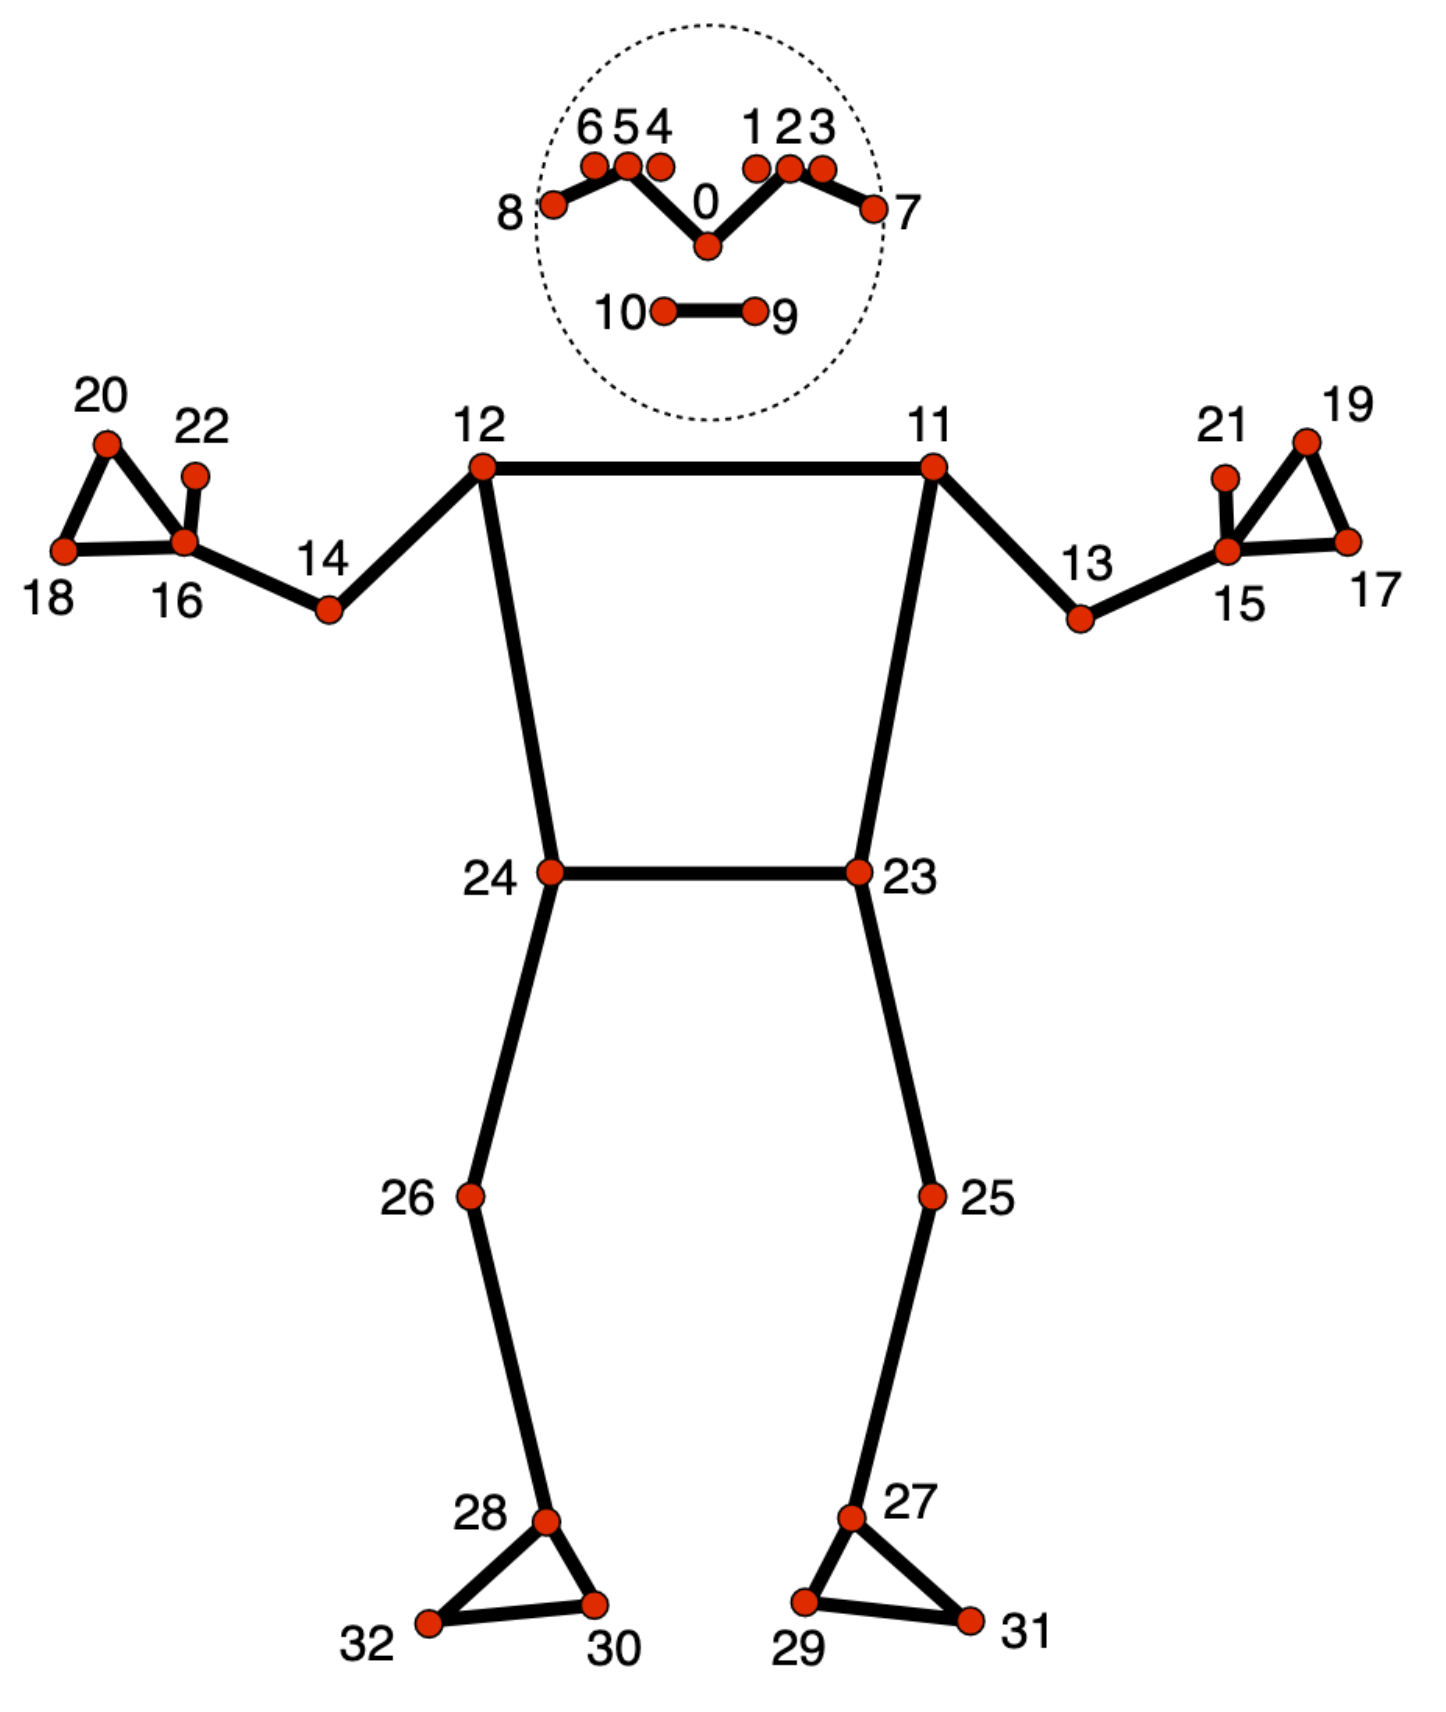

In [5]:
Image(filename="pose_landmarks_index.png") 

In [3]:
POSE_POINTS = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
POSE_MODEL = "pose_landmarker_heavy.task"

In [155]:
def find_pose(path):
    instance_frames = []
    instance_noise = []

    base_options = python.BaseOptions(model_asset_path=POSE_MODEL)
    options = vision.PoseLandmarkerOptions(base_options=base_options, running_mode=vision.RunningMode.VIDEO,)
    
    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, path, repeat_playback=False)

    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    align = rs.align(rs.stream.color)
    duration = playback.get_duration().total_seconds()

    color_profile = profile.get_stream(rs.stream.color).as_video_stream_profile()
    width = color_profile.width() # 1280 px
    height = color_profile.height() # 720 px

    previous_timestamp = -1
    frame_counter = 0

    try:
        while True:
            frames = pipeline.wait_for_frames()
            frames = align.process(frames)

            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not (depth_frame and color_frame):
                break
            
            image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(np.asanyarray(color_frame.get_data()), cv2.COLOR_BGR2RGB))

            timestamp = int(playback.get_position() / 1000)
            if timestamp <= previous_timestamp:
                timestamp = previous_timestamp + 1 
            previous_timestamp = timestamp    

            detection = vision.PoseLandmarker.create_from_options(options).detect_for_video(image, timestamp)

            if detection.pose_landmarks:
                pose = detection.pose_landmarks[0]
                for pose_point in POSE_POINTS:                        
                        point_x = int(np.clip(pose[pose_point].x * width, 0, width - 1))
                        point_y = int(np.clip(pose[pose_point].y * height, 0, height - 1))
                        depth_z = depth_frame.get_distance(point_x, point_y)
                        
                        instance_frames.append({
                            "frame": frame_counter,
                            "timestamp": timestamp,
                            "pose_point": pose_point,
                            "point_x": point_x,
                            "point_y": point_y,
                            "depth_z": depth_z,
                        })
                else:
                        instance_noise.append({
                            "frame": frame_counter,
                            "timestamp": timestamp,
                        })
                frame_counter += 1
            
            if playback.get_position() <= duration:
                break

    except Exception as error:
        print(f"Error al procesar {path}: {error}.")

    return instance_frames, instance_noise

In [ ]:
batch_frames = []
batch_noise = []
n = 1
for index, row in dataset_df.iterrows():
    path = row["path"]
    id = row["id"]
    sample = row["sample"]

    instance_frames, instance_noise = find_pose(path)

    instance_noise.extend([{
        "id": id,
        "sample": sample,
        "bad_frames": instance_noise
    }])
    
    for point in instance_frames:
        batch_frames.append({
            "id": id,
            "sample": sample,
            **point
        })
    
    print(f"{path} procesado.")
    n = n+1
        
frames_df = pd.DataFrame(batch_frames)
noise_df = pd.DataFrame(instance_noise)

data/train\DianaItzel_01.bag procesado.
data/train\DianaItzel_02.bag procesado.
data/train\DianaItzel_03.bag procesado.
data/train\DianaItzel_04.bag procesado.
data/train\DianaMinerva_01.bag procesado.
data/train\DianaMinerva_02.bag procesado.
data/train\DianaMinerva_03.bag procesado.
data/train\DianaMinerva_04.bag procesado.
data/train\Edgar_01.bag procesado.
data/train\Edgar_02.bag procesado.
data/train\Edgar_03.bag procesado.
data/train\Edgar_04.bag procesado.
data/train\Erick_01.bag procesado.
data/train\Erick_02.bag procesado.
data/train\Erick_03.bag procesado.
data/train\Erick_04.bag procesado.
data/train\Hussein_01.bag procesado.
data/train\Hussein_02.bag procesado.
data/train\Hussein_03.bag procesado.
data/train\Hussein_04.bag procesado.
data/train\Ian_01.bag procesado.
data/train\Ian_02.bag procesado.
data/train\Ian_03.bag procesado.
data/train\Ian_04.bag procesado.
data/train\Javier_01.bag procesado.
data/train\Javier_02.bag procesado.
data/train\Javier_03.bag procesado.
data

In [20]:
frames_df.to_csv("frames.csv", index=False)
noise_df.to_csv("noise.csv", index=False)

## Limpieza de datos

In [21]:
df = pd.read_csv("frames.csv")

errors = df[df["depth_z"] == 0]
error_counts = errors.groupby("pose_point").size().reset_index(name="depth_z = 0")

print(error_counts)
print(f"Errores de profundidad totales: {len(errors)}.")

    pose_point  depth_z = 0
0            0           49
1           11          114
2           12           94
3           13          216
4           14          265
5           15          607
6           16          750
7           23          545
8           24          581
9           25         1336
10          26         1345
11          27         1690
12          28         1822
13          29         1752
14          30         1890
15          31         2134
16          32         2054
Errores de profundidad totales: 17244.


Podemos observar que en la mayoría de *frames*, la detección de la profundidad de los puntos extraídos es más difícil para la parte inferior de los participantes (y las manos, aunque este punto no es tan relevante).

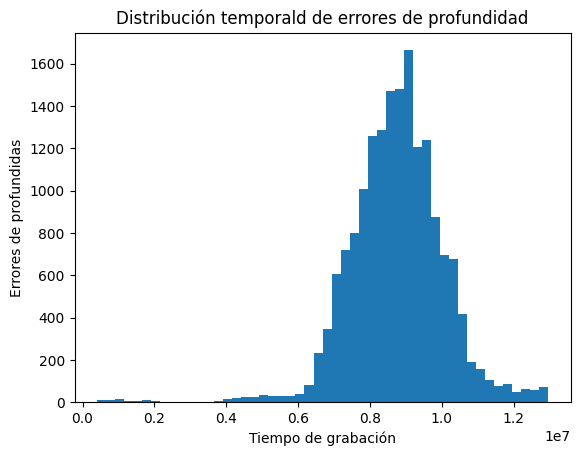

In [22]:
plt.figure()
plt.hist(errors["timestamp"], bins=50)
plt.xlabel("Tiempo de grabación")
plt.ylabel("Errores de profundidas")
plt.title("Distribución temporald de errores de profundidad")
plt.show()

Ya que la mayoría de los errores de profundidad se encuentran en el primer segundo de los videos, se eliminará este del conjunto de datos.

In [28]:
df = pd.read_csv("frames.csv")

t0 = df.groupby(["id", "sample"])["timestamp"].transform("min") # start of video
frames_trimmed = df[df["timestamp"] >= t0 + 1000]

frames_trimmed.to_csv("frames_trimmed.csv", index=False)

Se incluyen en el conjunto final de datos solo a aquellos *frames* en que al menos el 80% de los puntos de la pose se registran correctamente. Se completa el conjunto de puntos con interpolación lineal de ser necesario.

In [ ]:
df = pd.read_csv("frames_trimmed.csv")

df["valid_depth"] = df["depth_z"] > 0

valid_ratio = df.groupby("frame")["valid_depth"].mean()
good_frames = valid_ratio[valid_ratio >= 0.8]

last_good_frame = good_frames.index.max()
df = df[df["frame"] <= last_good_frame]
df = df.drop(columns="valid_depth")

df = df.sort_values("frame")
z = df["depth_z"].where(df["depth_z"] > 0, np.nan)

df["depth_z"] = (z.groupby(df["pose_point"]).transform(lambda x: x.interpolate(method="linear",limit_area="inside"))
)

df = df[df["depth_z"].notna()]

df = df.sort_values(["id", "sample", "frame", "pose_point", "timestamp"]).reset_index(drop=True)

df.to_csv("frames_clean.csv", index=False)

## Extracción de características

Se calcularán los ángulos entre articulaciones importantes, así como la posición de los pies para calcular la longitud de dichos pasos.

In [219]:
fx, fy = 600.0, 600.0
cx, cy = 640.0, 360.0

# (A, B, C) means angle at B
JOINT_ANGLES = {
    "left_knee":  (23, 25, 27),
    "right_knee": (24, 26, 28),
}

COM_JOINTS = [11, 12, 23, 24]

LEFT_ANKLE = 27
RIGHT_ANKLE = 28

def pixel_to_camera(x, y, z):
    X = (x - cx) * z / fx
    Y = (y - cy) * z / fy
    return np.array([X, Y, z], dtype=float)

def angle_3d(a, b, c):
    ba = a - b
    bc = c - b
    denom = np.linalg.norm(ba) * np.linalg.norm(bc)
    if denom == 0:
        return np.nan
    cosang = np.dot(ba, bc) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

df = pd.read_csv("frames_clean.csv")

df = df.sort_values(
    ["id", "sample", "frame", "pose_point"]
).reset_index(drop=True)

rows = []

for (vid, samp, frame), g in df.groupby(
    ["id", "sample", "frame"], sort=False
):
    joints = {
        r.pose_point: pixel_to_camera(
            r.point_x, r.point_y, r.depth_z
        )
        for r in g.itertuples(index=False)
    }

    if all(j in joints for j in COM_JOINTS):
        com = np.mean([joints[j] for j in COM_JOINTS], axis=0)
    else:
        continue  # skip frame if CoM undefined

    base_row = {
        "id": vid,
        "sample": samp,
        "frame": frame,
        "com_x": com[0],
        "com_y": com[1],
        "com_z": com[2],
    }

    for name, (a, b, c) in JOINT_ANGLES.items():
        if a in joints and b in joints and c in joints:
            base_row[name] = angle_3d(
                joints[a], joints[b], joints[c]
            )

    if LEFT_ANKLE in joints:
        base_row["left_ankle_z"] = joints[LEFT_ANKLE][2]
    if RIGHT_ANKLE in joints:
        base_row["right_ankle_z"] = joints[RIGHT_ANKLE][2]

    rows.append(base_row)

feat_df = pd.DataFrame(rows)

feat_df["step_length"] = np.nan

for (vid, samp), g in feat_df.groupby(["id", "sample"]):
    g = g.sort_values("frame")

    left_peaks = (
        (g["left_ankle_z"].shift(1) < g["left_ankle_z"]) &
        (g["left_ankle_z"].shift(-1) < g["left_ankle_z"])
    )

    right_peaks = (
        (g["right_ankle_z"].shift(1) < g["right_ankle_z"]) &
        (g["right_ankle_z"].shift(-1) < g["right_ankle_z"])
    )

    left_steps = g.loc[left_peaks, "left_ankle_z"].to_numpy(dtype=float)
    right_steps = g.loc[right_peaks, "right_ankle_z"].to_numpy(dtype=float)
    n = min(len(left_steps), len(right_steps))
    steps = np.abs(left_steps[:n] - right_steps[:n])

    idx = g.index[left_peaks | right_peaks][:n]
    feat_df.loc[idx, "step_length"] = steps

feat_df = feat_df.sort_values(
    ["id", "sample", "frame"]
).reset_index(drop=True)

feat_df.to_csv("gait_features.csv", index=False)


In [220]:
df = pd.read_csv("gait_features.csv")

window_size = 10
step = 5

angle_features = ["left_knee", "right_knee"]
pos_features = ["com_x", "com_y", "com_z", "left_ankle_z", "right_ankle_z"]

def windowed_features(group, name):
    group = group.sort_values("frame")
    rows = []
    for start in range(0, len(group) - window_size + 1, step):
        win = group.iloc[start:start+window_size]
        feat = {}
        for f in pos_features:
            vals = win[f].to_numpy(dtype=float)
            feat[f"{f}_mean"] = np.nanmean(vals)
            feat[f"{f}_std"] = np.nanstd(vals)
            feat[f"{f}_min"] = np.nanmin(vals)
            feat[f"{f}_max"] = np.nanmax(vals)
            diffs = np.diff(vals)
            feat[f"{f}_vel_mean"] = np.nanmean(diffs)
            feat[f"{f}_vel_std"] = np.nanstd(diffs)
        for f in angle_features:
            vals = win[f].to_numpy(dtype=float)
            feat[f"{f}_mean"] = np.nanmean(vals)
            feat[f"{f}_std"] = np.nanstd(vals)
            feat[f"{f}_min"] = np.nanmin(vals)
            feat[f"{f}_max"] = np.nanmax(vals)
            diffs = np.diff(vals)
            feat[f"{f}_vel_mean"] = np.nanmean(diffs)
            feat[f"{f}_vel_std"] = np.nanstd(diffs)
        vals = win["step_length"].to_numpy(dtype=float)
        feat["step_length_mean"] = np.nanmean(vals)
        feat["step_length_std"] = np.nanstd(vals)
        feat["step_length_min"] = np.nanmin(vals)
        feat["step_length_max"] = np.nanmax(vals)
        feat["id"] = name[0]
        feat["sample"] = name[1]
        rows.append(feat)
    return pd.DataFrame(rows)

## Modelos de clasificación

Se probarán tres modelos de aprendizaje automático clásico: 
- Random Forest
- SVM
- k-NN

El mejor se probará con el conjunto de validación externa almacenado en `data/test`.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:34: RuntimeWarning: Mean of empty slice
  feat["step_length_mean"] = np.nanmean(vals)
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1997: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:36: RuntimeWarning: All-NaN slice encountered
  feat["step_length_min"] = np.nanmin(vals)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:37: RuntimeWarning: All-NaN slice encountered
  feat["step_length_max"] = np.nanmax(vals)


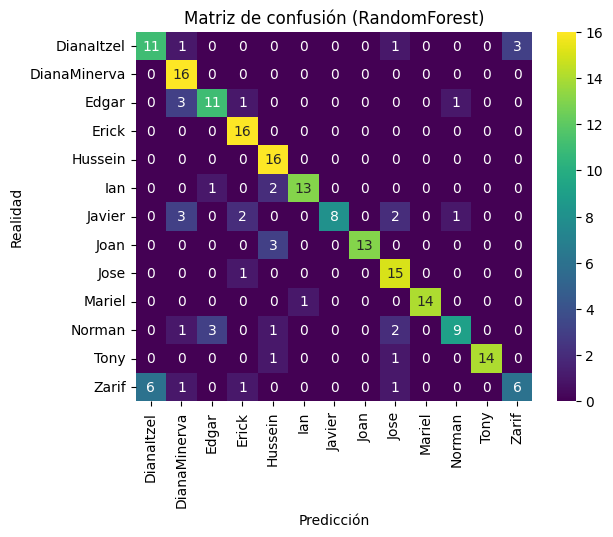

              precision    recall  f1-score   support

  DianaItzel       0.65      0.69      0.67        16
DianaMinerva       0.64      1.00      0.78        16
       Edgar       0.73      0.69      0.71        16
       Erick       0.76      1.00      0.86        16
     Hussein       0.70      1.00      0.82        16
         Ian       0.93      0.81      0.87        16
      Javier       1.00      0.50      0.67        16
        Joan       1.00      0.81      0.90        16
        Jose       0.68      0.94      0.79        16
      Mariel       1.00      0.93      0.97        15
      Norman       0.82      0.56      0.67        16
        Tony       1.00      0.88      0.93        16
       Zarif       0.67      0.40      0.50        15

    accuracy                           0.79       206
   macro avg       0.81      0.79      0.78       206
weighted avg       0.81      0.79      0.78       206

Weighted F1 score: 0.7794555908156997


In [222]:
windowed_df = pd.concat([windowed_features(g, name) for name, g in df.groupby(["id","sample"])]).reset_index(drop=True)

X = windowed_df.drop(columns=["id","sample"])
y = windowed_df["id"]
samples = windowed_df["sample"]

clf = RandomForestClassifier(n_estimators=200, random_state=42)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

video_preds = []
video_labels = []

for train_idx, test_idx in cv.split(X, y):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_test_pred = X.iloc[test_idx].copy()
    y_test_pred = clf.predict(X.iloc[test_idx])

    test_videos = windowed_df.iloc[test_idx][["id","sample"]].values
    video_dict = {}
    for (vid, samp), pred in zip(test_videos, y_test_pred):
        key = (vid, samp)
        if key not in video_dict:
            video_dict[key] = []
        video_dict[key].append(pred)
    for (vid, samp), preds in video_dict.items():
        preds = np.array(preds)
        unique, counts = np.unique(preds, return_counts=True)
        majority = unique[np.argmax(counts)]
        video_preds.append(majority)
        video_labels.append(vid)

video_labels = np.array(video_labels)
video_preds = np.array(video_preds)

cm = confusion_matrix(video_labels, video_preds, labels=np.unique(video_labels))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(video_labels), yticklabels=np.unique(video_labels), cmap='viridis')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de confusión (RandomForest)")
plt.show()

print(classification_report(video_labels, video_preds, labels=np.unique(video_labels)))
print(f"Weighted F1 score: {f1_score(video_labels, video_preds, average='weighted')}")

rf_model = clf.fit(X, y)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:34: RuntimeWarning: Mean of empty slice
  feat["step_length_mean"] = np.nanmean(vals)
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1997: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:36: RuntimeWarning: All-NaN slice encountered
  feat["step_length_min"] = np.nanmin(vals)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:37: RuntimeWarning: All-NaN slice encountered
  feat["step_length_max"] = np.nanmax(vals)


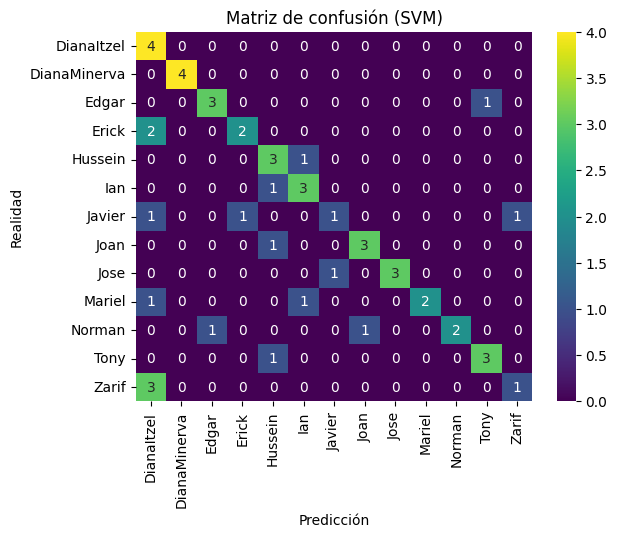

              precision    recall  f1-score   support

  DianaItzel       0.36      1.00      0.53         4
DianaMinerva       1.00      1.00      1.00         4
       Edgar       0.75      0.75      0.75         4
       Erick       0.67      0.50      0.57         4
     Hussein       0.50      0.75      0.60         4
         Ian       0.60      0.75      0.67         4
      Javier       0.50      0.25      0.33         4
        Joan       0.75      0.75      0.75         4
        Jose       1.00      0.75      0.86         4
      Mariel       1.00      0.50      0.67         4
      Norman       1.00      0.50      0.67         4
        Tony       0.75      0.75      0.75         4
       Zarif       0.50      0.25      0.33         4

    accuracy                           0.65        52
   macro avg       0.72      0.65      0.65        52
weighted avg       0.72      0.65      0.65        52

Weighted F1 score: 0.6521978021978023.


In [223]:
windowed_df = pd.concat([windowed_features(g, name) for name, g in df.groupby(["id","sample"])]).reset_index(drop=True)

X = windowed_df.drop(columns=["id","sample"])
y = windowed_df["id"]
groups = windowed_df["sample"]

X_filled = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

clf = SVC(kernel='linear', decision_function_shape='ovr', probability=False, random_state=42)
logo = LeaveOneGroupOut()

video_preds = []
video_labels = []
video_std = []

for train_idx, test_idx in logo.split(X_scaled, y, groups=groups):
    clf.fit(X_scaled[train_idx], y.iloc[train_idx])
    y_test_pred = clf.predict(X_scaled[test_idx])
    
    test_videos = windowed_df.iloc[test_idx][["id","sample"]].values
    video_dict = {}
    for (vid, samp), pred in zip(test_videos, y_test_pred):
        key = (vid, samp)
        if key not in video_dict:
            video_dict[key] = []
        video_dict[key].append(pred)
    
    for (vid, samp), preds in video_dict.items():
        preds = np.array(preds)
        unique, counts = np.unique(preds, return_counts=True)
        majority = unique[np.argmax(counts)]
        video_preds.append(majority)
        video_labels.append(vid)
        
        class_map = {cls: i for i, cls in enumerate(np.unique(y))}
        preds_encoded = np.array([class_map[p] for p in preds])
        video_std.append(np.std(preds_encoded))

video_labels = np.array(video_labels)
video_preds = np.array(video_preds)

cm = confusion_matrix(video_labels, video_preds, labels=np.unique(video_labels))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(video_labels), yticklabels=np.unique(video_labels), cmap='viridis')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de confusión (SVM)")
plt.show()

print(classification_report(video_labels, video_preds, labels=np.unique(video_labels)))
print(f"Weighted F1 score: {f1_score(video_labels, video_preds, average='weighted')}.")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:34: RuntimeWarning: Mean of empty slice
  feat["step_length_mean"] = np.nanmean(vals)
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1997: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:36: RuntimeWarning: All-NaN slice encountered
  feat["step_length_min"] = np.nanmin(vals)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\3860077476.py:37: RuntimeWarning: All-NaN slice encountered
  feat["step_length_max"] = np.nanmax(vals)


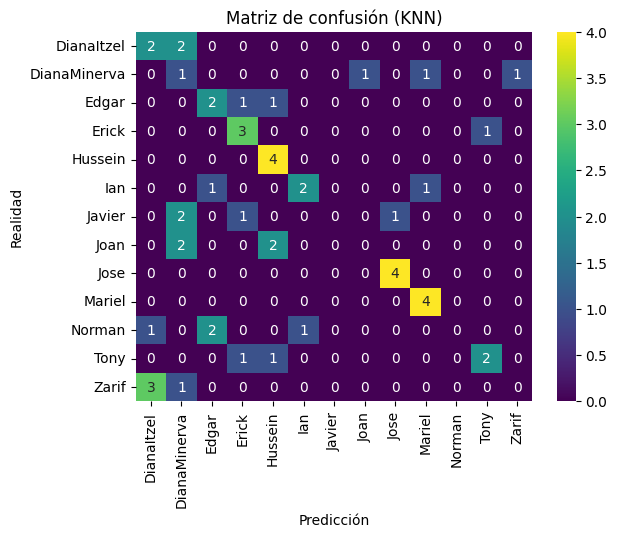

              precision    recall  f1-score   support

  DianaItzel       0.33      0.50      0.40         4
DianaMinerva       0.12      0.25      0.17         4
       Edgar       0.40      0.50      0.44         4
       Erick       0.50      0.75      0.60         4
     Hussein       0.50      1.00      0.67         4
         Ian       0.67      0.50      0.57         4
      Javier       0.00      0.00      0.00         4
        Joan       0.00      0.00      0.00         4
        Jose       0.80      1.00      0.89         4
      Mariel       0.67      1.00      0.80         4
      Norman       0.00      0.00      0.00         4
        Tony       0.67      0.50      0.57         4
       Zarif       0.00      0.00      0.00         4

    accuracy                           0.46        52
   macro avg       0.36      0.46      0.39        52
weighted avg       0.36      0.46      0.39        52

Weighted F1 score: 0.39304029304029303.


e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Prec

: 

In [ ]:
windowed_df = pd.concat([windowed_features(g, name) for name, g in df.groupby(["id","sample"])]).reset_index(drop=True)

X = windowed_df.drop(columns=["id","sample"])
y = windowed_df["id"]
groups = windowed_df["sample"]

X_filled = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

clf = KNeighborsClassifier(n_neighbors=5)
logo = LeaveOneGroupOut()

video_preds = []
video_labels = []

for train_idx, test_idx in logo.split(X_scaled, y, groups=groups):
    clf.fit(X_scaled[train_idx], y.iloc[train_idx])
    y_test_pred = clf.predict(X_scaled[test_idx])
    
    test_videos = windowed_df.iloc[test_idx][["id","sample"]].values
    video_dict = {}
    for (vid, samp), pred in zip(test_videos, y_test_pred):
        key = (vid, samp)
        if key not in video_dict:
            video_dict[key] = []
        video_dict[key].append(pred)
    
    for (vid, samp), preds in video_dict.items():
        preds = np.array(preds)
        unique, counts = np.unique(preds, return_counts=True)
        majority = unique[np.argmax(counts)]
        video_preds.append(majority)
        video_labels.append(vid)

video_labels = np.array(video_labels)
video_preds = np.array(video_preds)

cm = confusion_matrix(video_labels, video_preds, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y), cmap='viridis')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de confusión (KNN)")
plt.show()

print(classification_report(video_labels, video_preds, labels=np.unique(y)))
print(f"Weighted F1 score: {f1_score(video_labels, video_preds, average='weighted')}.")

### Resumen de modelos
- Random Forest: F1 score = 0.7794555908156997
- SVM: F1 score = 0.6521978021978023.
- k-NN: F1 score = 0.39304029304029303.

Random Forest fue el mejor.

Podemos notar que en todos los casos, Javier y Zarif fueron las clases con peores resultados. En el caso de Zarif, su caminata se confunde con la de Diana Itzel; esto puede deberse a sus estaturas similares.

## Validación Externa

Se repite el procesado para el conjunto de validación, y se utiliza el modelo RandomForest anterior. 

In [158]:
test_path = "data/test"

test_df = pd.DataFrame(columns=["id", "path"])

rows = []
for file_name in os.listdir(test_path):
    if not file_name.endswith(".bag"):
        continue
    name, _ = os.path.splitext(file_name)
    rows.append({
        "id": name,
        "path": os.path.join(test_path, file_name),
    })

test_df = pd.concat([test_df, pd.DataFrame(rows)], ignore_index=True)

test_df

,id,path
0,163238,data/test\163238.bag
1,163329,data/test\163329.bag
2,163516,data/test\163516.bag
3,163718,data/test\163718.bag
4,163749,data/test\163749.bag
5,163827,data/test\163827.bag
6,163934,data/test\163934.bag
7,164008,data/test\164008.bag
8,164123,data/test\164123.bag
9,164209,data/test\164209.bag


In [159]:
batch_frames = []
batch_noise = []
n = 1
for index, row in test_df.iterrows():
    id = row["id"]
    path = row["path"]

    instance_frames, instance_noise = find_pose(path)

    instance_noise.extend([{
        "id": id,
        "bad_frames": instance_noise
    }])
    
    for point in instance_frames:
        batch_frames.append({
            "id": id,
            **point
        })
    
    print(f"{path} procesado.")
    n = n+1
        
test_frames_df = pd.DataFrame(batch_frames)
test_noise_df = pd.DataFrame(instance_noise)

data/test\163238.bag procesado.
data/test\163329.bag procesado.
data/test\163516.bag procesado.
data/test\163718.bag procesado.
data/test\163749.bag procesado.
data/test\163827.bag procesado.
data/test\163934.bag procesado.
data/test\164008.bag procesado.
data/test\164123.bag procesado.
data/test\164209.bag procesado.
data/test\164242.bag procesado.
data/test\164315.bag procesado.


In [160]:
test_frames_df.to_csv("test_frames.csv", index=False)
test_noise_df.to_csv("test_noise.csv", index=False)

In [161]:
df = pd.read_csv("test_frames.csv")

t0 = df.groupby(["id"])["timestamp"].transform("min") # start of video
frames_trimmed = df[df["timestamp"] >= t0 + 1000]

frames_trimmed.to_csv("test_frames_trimmed.csv", index=False)

In [162]:
df = pd.read_csv("test_frames_trimmed.csv")

df["valid_depth"] = df["depth_z"] > 0

valid_ratio = df.groupby("frame")["valid_depth"].mean()
good_frames = valid_ratio[valid_ratio >= 0.8]

last_good_frame = good_frames.index.max()
df = df[df["frame"] <= last_good_frame]
df = df.drop(columns="valid_depth")

df = df.sort_values("frame")
z = df["depth_z"].where(df["depth_z"] > 0, np.nan)

df["depth_z"] = (z.groupby(df["pose_point"]).transform(lambda x: x.interpolate(method="linear",limit_area="inside"))
)

df = df[df["depth_z"].notna()]

df = df.sort_values(["id", "frame", "pose_point", "timestamp"]).reset_index(drop=True)

df.to_csv("test_frames_clean.csv", index=False)

In [165]:
df = pd.read_csv("test_frames_clean.csv")

df = df.sort_values(
    ["id", "frame", "pose_point"]
).reset_index(drop=True)

rows = []

for (vid, frame), g in df.groupby(
    ["id", "frame"], sort=False
):
    joints = {
        r.pose_point: pixel_to_camera(
            r.point_x, r.point_y, r.depth_z
        )
        for r in g.itertuples(index=False)
    }

    if all(j in joints for j in COM_JOINTS):
        com = np.mean([joints[j] for j in COM_JOINTS], axis=0)
    else:
        continue  # skip frame if CoM undefined

    base_row = {
        "id": vid,
        "frame": frame,
        "com_x": com[0],
        "com_y": com[1],
        "com_z": com[2],
    }

    for name, (a, b, c) in JOINT_ANGLES.items():
        if a in joints and b in joints and c in joints:
            base_row[name] = angle_3d(
                joints[a], joints[b], joints[c]
            )

    if LEFT_ANKLE in joints:
        base_row["left_ankle_z"] = joints[LEFT_ANKLE][2]
    if RIGHT_ANKLE in joints:
        base_row["right_ankle_z"] = joints[RIGHT_ANKLE][2]

    rows.append(base_row)

test_feat_df = pd.DataFrame(rows)

test_feat_df["step_length"] = np.nan

for (vid), g in test_feat_df.groupby(["id"]):
    g = g.sort_values("frame")

    left_peaks = (
        (g["left_ankle_z"].shift(1) < g["left_ankle_z"]) &
        (g["left_ankle_z"].shift(-1) < g["left_ankle_z"])
    )

    right_peaks = (
        (g["right_ankle_z"].shift(1) < g["right_ankle_z"]) &
        (g["right_ankle_z"].shift(-1) < g["right_ankle_z"])
    )

    left_steps = g.loc[left_peaks, "left_ankle_z"].to_numpy(dtype=float)
    right_steps = g.loc[right_peaks, "right_ankle_z"].to_numpy(dtype=float)
    n = min(len(left_steps), len(right_steps))
    steps = np.abs(left_steps[:n] - right_steps[:n])

    idx = g.index[left_peaks | right_peaks][:n]
    test_feat_df.loc[idx, "step_length"] = steps

test_feat_df = test_feat_df.sort_values(
    ["id", "frame"]
).reset_index(drop=True)

test_feat_df.to_csv("test_gait_features.csv", index=False)

In [211]:
df = pd.read_csv("test_gait_features.csv")

window_size = 10
step = 5

angle_features = ["left_knee", "right_knee"]
pos_features = ["com_x", "com_y", "com_z", "left_ankle_z", "right_ankle_z"]

def test_windowed_features(group):
    group = group.sort_values("frame")
    rows = []
    for start in range(0, len(group) - window_size + 1, step):
        win = group.iloc[start:start+window_size]
        feat = {}
        for f in pos_features:
            vals = win[f].to_numpy(dtype=float)
            feat[f"{f}_mean"] = np.nanmean(vals)
            feat[f"{f}_std"] = np.nanstd(vals)
            feat[f"{f}_min"] = np.nanmin(vals)
            feat[f"{f}_max"] = np.nanmax(vals)
            diffs = np.diff(vals)
            feat[f"{f}_vel_mean"] = np.nanmean(diffs)
            feat[f"{f}_vel_std"] = np.nanstd(diffs)
        for f in angle_features:
            vals = win[f].to_numpy(dtype=float)
            feat[f"{f}_mean"] = np.nanmean(vals)
            feat[f"{f}_std"] = np.nanstd(vals)
            feat[f"{f}_min"] = np.nanmin(vals)
            feat[f"{f}_max"] = np.nanmax(vals)
            diffs = np.diff(vals)
            feat[f"{f}_vel_mean"] = np.nanmean(diffs)
            feat[f"{f}_vel_std"] = np.nanstd(diffs)
        vals = win["step_length"].to_numpy(dtype=float)
        feat["step_length_mean"] = np.nanmean(vals)
        feat["step_length_std"] = np.nanstd(vals)
        feat["step_length_min"] = np.nanmin(vals)
        feat["step_length_max"] = np.nanmax(vals)
        rows.append(feat)
    return pd.DataFrame(rows)

In [218]:
df_test = pd.read_csv("test_gait_features.csv")
df_test.columns = df_test.columns.str.strip()
df_test["id"] = df_test["id"].astype(str)  # ensure string IDs

windowed_dfs = []
video_ids_per_window = []

for vid, g in df_test.groupby("id"):
    win_df = test_windowed_features(g)
    windowed_dfs.append(win_df)
    n_windows = len(win_df)
    video_ids_per_window.extend([vid] * n_windows)

windowed_df_test = pd.concat(windowed_dfs).reset_index(drop=True)

X_test = windowed_df_test.copy()
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test = X_test.fillna(0)

y_pred_windows = clf.predict(X_test)

video_preds = {}
for vid, pred in zip(video_ids_per_window, y_pred_windows):
    if vid not in video_preds:
        video_preds[vid] = []
    video_preds[vid].append(pred)

for vid, preds in video_preds.items():
    majority = Counter(preds).most_common(1)[0][0]
    print(f"{vid}.bag: Predicción = {majority}")

163238.bag: Predicción = DianaItzel
163329.bag: Predicción = DianaItzel
163516.bag: Predicción = DianaItzel
163718.bag: Predicción = DianaItzel
163749.bag: Predicción = Zarif
163827.bag: Predicción = DianaItzel
163934.bag: Predicción = DianaItzel
164008.bag: Predicción = DianaItzel
164123.bag: Predicción = DianaItzel
164209.bag: Predicción = DianaItzel
164242.bag: Predicción = Zarif
164315.bag: Predicción = DianaItzel


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\2013721122.py:34: RuntimeWarning: Mean of empty slice
  feat["step_length_mean"] = np.nanmean(vals)
e:\My Files\Documents\Documents\Grad School\Ciencia de Datos para Sensores Inteligentes\Práctica 2\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1997: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\2013721122.py:36: RuntimeWarning: All-NaN slice encountered
  feat["step_length_min"] = np.nanmin(vals)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7432\2013721122.py:37: RuntimeWarning: All-NaN slice encountered
  feat["step_length_max"] = np.nanmax(vals)


En ninguno de los casos se realizó la predicción correcta (de hecho las clases predichas no forman parte de los participantes del conjunto de validación). Esto puede deberse a las características adicionales presentes en estos nuevos videos, como objetos en las manos del sujeto o la participante que no formó parte del conjunto de entrenamiento.

Sin embargo, los videos clasificados como `DianaItzel` son los correspondientes a esta nueva participante. Es posible que estas predicciones erróneas se deban a que de las tres participantes originales, se predijo a la persona con carácterísticas más similares.

De manera similar, los videos clasificados como `Zarif` corresponden a videos de participantes del conjunto de datos original, pero realizando actividades distintas como lo es tomar de una taza y sujetarse las manos (lo cual ocluye los puntos de la pose necesarios para el procesamiento de los videos).